In [17]:
import json
import w3d2_tests
import torch
import transformers

import matplotlib.pyplot as plt

In [15]:
# Model specs:
#   "num_layers": 2,
#   "num_heads": 8,
#   "head_size": 32,
#   "vocab_size": 50259,
#   "hidden_size": 256,
#   "max_position_embeddings": 512
model = w3d2_tests.get_minigpt("model.pt")
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer._add_tokens(["[BEGIN]", "[END]"])
tokenizer.pad_token = "[END]"
tokenizer.eos_token = "[END]"
# 50258 is the pad_token_id
# 50257 is the BEGIN token id

with open("test_tokens_owt_subset.json") as f:
    test_tokens = torch.LongTensor(json.load(f))[:,:512]

In [16]:
import einops
# qkv should be string "q", "k", "v", or "o"
def get_weight(model, layer, head, qkvo):
    if qkvo == "o":
        weight_matrix = model.blocks[layer].project_output.weight
        weight_matrix = einops.rearrange(weight_matrix, "(heads headsize) embed -> heads headsize embed", heads=8)
        return weight_matrix[head]
    else:
        weight_matrix = model.blocks[layer].project_qkv.weight
        # 768 by 256
        weight_matrix = einops.rearrange(weight_matrix, "(qkv heads headsize) embed -> qkv heads headsize embed", qkv=3, heads=8)
        qkv_index = {
            "q": 0,
            "k": 1,
            "v": 2,
        }[qkvo]
        weight_matrix = weight_matrix[qkv_index, head] 
        # 32 x 256
        return weight_matrix

In [5]:
def mask_attention(scores, neg_inf_value):
    seq_len = scores.shape[0]
    assert scores.shape == (seq_len, seq_len)
    neg_inf = torch.tensor(neg_inf_value, dtype=torch.float32).to(scores.device)
    q_ind = torch.arange(seq_len).unsqueeze(1)
    k_ind = torch.arange(seq_len).unsqueeze(0)
    mask = (q_ind < k_ind).to(scores.device)
    return torch.where(mask, neg_inf, scores)

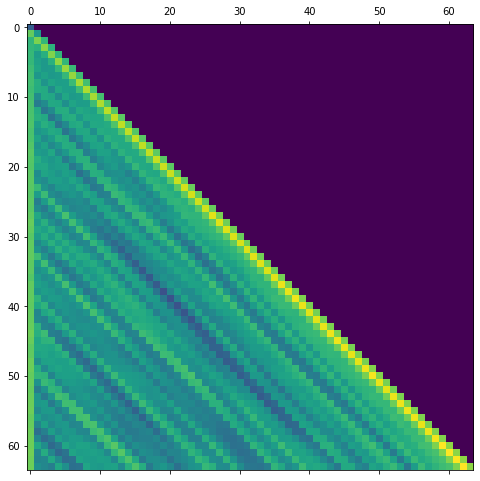

In [21]:
# gets the attention between left_vector and right_vector at the layer and head
def get_attention_term(model, layer, head, left_vector, right_vector):
    k_weight = get_weight(model, layer, head, "k")
    q_weight = get_weight(model, layer, head, "q")
    QK = q_weight.T @ k_weight
    attention_matrix = (left_vector @ QK) @ right_vector.T
    attention_matrix = mask_attention(attention_matrix, -100)
    return attention_matrix.detach()

pos_embeds = model.pos_embedding(torch.arange(64))
attention_term = get_attention_term(model, 0, 0, pos_embeds, pos_embeds)
plt.matshow(attention_term.detach().numpy())
plt.gcf().set_size_inches((8,8))

Sentence: [BEGIN]  Conservationists are making another push to get federal wildlife officials to devote more resources


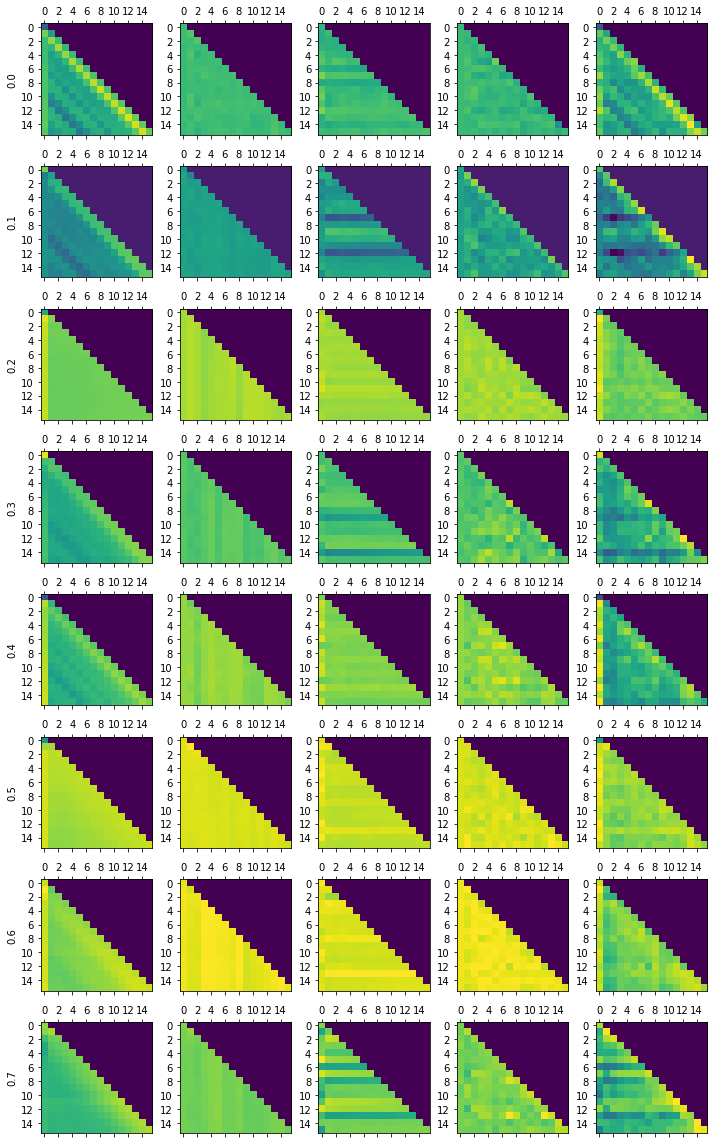

In [11]:
LEN = 16
LAYER = 0
NUM_HEADS=8
tokens = test_tokens[3][:LEN]

fig, axs = plt.subplots(NUM_HEADS, 5, figsize=(10,16))

token_embeds = model.token_embedding(tokens)
pos_embeds = model.pos_embedding(torch.arange(LEN))
summed_embeds = token_embeds + pos_embeds

for head in range(NUM_HEADS):
    summed_matrix = get_attention_term(model, LAYER, head, summed_embeds, summed_embeds)
    min_of_summed = torch.min(summed_matrix)
    max_of_summed = torch.max(summed_matrix)
    def show_matrix(ax, left_vec, right_vec):
        ax.matshow(get_attention_term(model, LAYER, head, left_vec, right_vec), vmin=min_of_summed, vmax=max_of_summed)

    show_matrix(axs[head][0], pos_embeds, pos_embeds)
    show_matrix(axs[head][1], pos_embeds, token_embeds)
    show_matrix(axs[head][2], token_embeds, pos_embeds)
    show_matrix(axs[head][3], token_embeds, token_embeds)
    show_matrix(axs[head][4], summed_embeds, summed_embeds)
    axs[head][0].set_ylabel(f"{LAYER}.{head}")

print("Sentence:", tokenizer.decode(tokens))
plt.tight_layout()
plt.savefig("layer0-terms.png", facecolor="white", transparent=False)

Each row of the grid of figures above is one of the heads on the 0th layer, each column is one of the terms of its attention score. The last column is the total attention score.

Within a cell, the rows are the "attention to" dimension and each column is "attention from". Thus we softmax each row to obtain the final attention allocation.

The first figure in each row is the position-position embeddings. This shows how a head allocates attention purely based on the relative position of the tokens, ignoring the sentence content. Notable examples are head 0.0 which pays strong attention to the previous token, 0.2 which cares not at all about position (except for differentiating the start token) and 0.7 which (all else equal) cares about tokens nearby to the current token.

The second figure in each row is the position-token terms, which means how much a given position attends to different tokens. There's not much to see in this figures, as where you are in the sequence doesn't tell the model much about what tokens it should pay atttention to.

The third figure is token-position. From this we can see that some heads (especially 0.7 and 0.5) use their token to decide whether to pay attention to the start token (at position 0) or the rest of the positions (containing the sample).

The fourth figure in the row is the token-token attention. Some heads seem to care about very particular token-token combinations (like 0.7), others care about most token-token combinations (like 0.6) while 0.0 mostly disregards this information and just shifts by 1.

The fifth is the sum of the above (pre soft max)

In [12]:
def get_intermediate_embedding(model, input_ids):
    input_ids = input_ids.unsqueeze(0)
    emb = model.token_embedding(input_ids)
    return (emb + model.blocks[0](emb, model.pos_embedding)).squeeze()

def get_intermediate_embedding_headwise(model, input_ids):
    input_ids = input_ids.unsqueeze(0)
    emb = model.token_embedding(input_ids)
    return torch.concat([emb, model.blocks[0].forward_headwise(emb, model.pos_embedding)[0]], dim=0)

In [13]:
# looks at layer 1 head `head`. visualizes query tokens[-1] vs all (num_heads + 1) 
# terms coming from residual stream for the key
def attention_scores_by_k_term(model, tokens, head):
    num_tokens = tokens.shape[0]
    induction_q_weight = get_weight(model, layer=1, head=head, qkvo="q")
    intermediate_embeddings = get_intermediate_embedding(model, tokens)
    query = induction_q_weight @ intermediate_embeddings[-1]
    
    induction_k_weight = get_weight(model, layer=1, head=head, qkvo="k")
    intermediate_headwise = get_intermediate_embedding_headwise(model, tokens)

    keys_headwise = torch.einsum("he,nqe->nqh", induction_k_weight, intermediate_headwise)
    attention_headwise = torch.einsum("h,nqh->nq", query, keys_headwise)
    
    plt.matshow(attention_headwise.detach())
    words = tokenizer.batch_decode([[t] for t in tokens])
    plt.xticks(range(num_tokens), words, rotation=45, horizontalalignment="left")
    plt.yticks(range(NUM_HEADS+1), ["residual"]+[f"output of 0.{h}" for h in range(NUM_HEADS)])
    plt.gcf().set_size_inches((16,5))
    plt.colorbar()

# attention_scores_by_k_term(model, test_tokens[40][:31], 4)

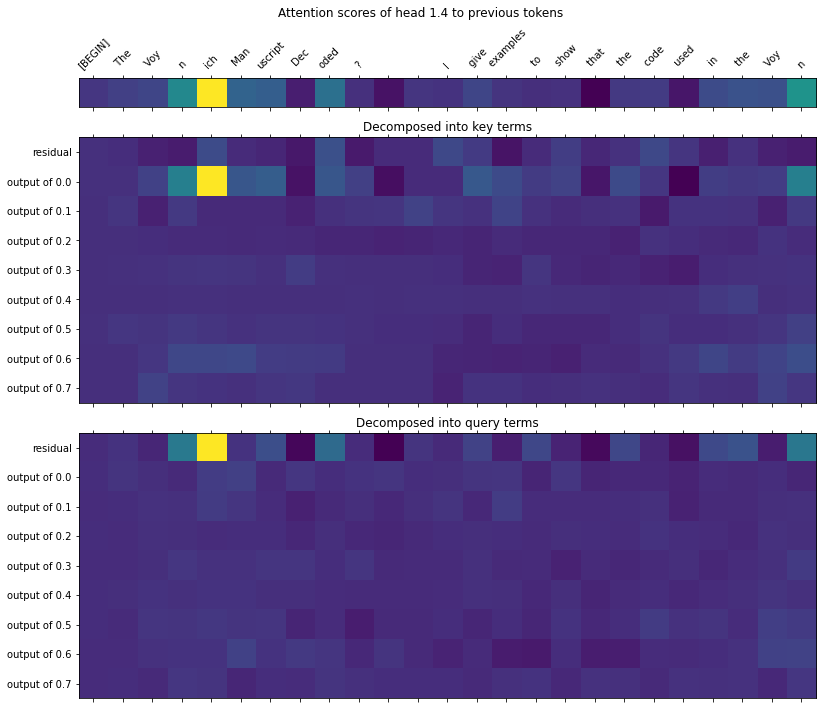

In [14]:
# same as attention_scores_by_k_term but also does another plot decomposing q terms
def attention_scores_by_q_and_k_terms(model, tokens, head):
    num_tokens = tokens.shape[0]
    
    induction_q_weight = get_weight(model, layer=1, head=head, qkvo="q")
    induction_k_weight = get_weight(model, layer=1, head=head, qkvo="k")
    intermediate_headwise = get_intermediate_embedding_headwise(model, tokens)
    
    query_headwise = torch.einsum("he,ne->nh", induction_q_weight, intermediate_headwise[:,-1,:]) # shape: terms, head_size
    keys_headwise = torch.einsum("he,nqe->nqh", induction_k_weight, intermediate_headwise)
    # n = m = num_heads, q = seq_len, h = head_size
    attention_q_terms = torch.einsum("mh,nqh->mq", query_headwise, keys_headwise)
    attention_k_terms = torch.einsum("mh,nqh->nq", query_headwise, keys_headwise)
    attention = torch.einsum("mh,nqh->q", query_headwise, keys_headwise)

    fig, axs = plt.subplots(3,1, figsize=(12,10), sharex=True, gridspec_kw={"height_ratios":(1,9,9)})
    axs[0].matshow(attention.detach().unsqueeze(0))    
    axs[1].matshow(attention_k_terms.detach())
    axs[2].matshow(attention_q_terms.detach())
    
    
    words = tokenizer.batch_decode([[t] for t in tokens])
    axs[0].tick_params('both', labeltop=True, labelrotation=45)
    axs[0].set_yticks([])
    axs[0].set_xticks(range(num_tokens))
    axs[0].set_xticklabels(labels=words)
    
    axs[1].set_yticks(range(NUM_HEADS+1))
    axs[1].set_yticklabels(["residual"]+[f"output of 0.{h}" for h in range(NUM_HEADS)])

    axs[2].tick_params('x', labeltop=False)
    axs[2].set_yticks(range(NUM_HEADS+1))
    axs[2].set_yticklabels(["residual"]+[f"output of 0.{h}" for h in range(NUM_HEADS)])

    fig.suptitle(f"Attention scores of head 1.{head} to previous tokens")
    axs[1].set_title("Decomposed into key terms")
    axs[2].set_title("Decomposed into query terms")
    
    plt.tight_layout()

    
attention_scores_by_q_and_k_terms(model, test_tokens[1][:25], 4)